<a href="https://colab.research.google.com/github/jayuan101/flagged-and-not-flagged-NLP-Model/blob/main/flagged_and_not_flagged_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from spacy import displacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import *
from sklearn.naive_bayes import  MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# read_data
train = pd.read_csv('Sheet_1.csv')
test = pd.read_csv('Sheet_2.csv', encoding = 'latin1')

In [5]:
train.head(10)

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN
5,response_6,not_flagged,a couple of years ago my friends was going to ...,NaN,NaN,NaN,NaN,NaN
6,response_7,flagged,Roommate when he was going through death and l...,NaN,NaN,NaN,NaN,NaN
7,response_8,flagged,i've had a couple of friends (you could say mo...,NaN,NaN,NaN,NaN,NaN
8,response_9,not_flagged,Listened to someone talk about relationship tr...,NaN,NaN,NaN,NaN,NaN
9,response_10,flagged,I will always listen. I comforted my sister wh...,NaN,NaN,NaN,NaN,NaN


In [6]:
test.head(10)

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
5,resume_6,not_flagged,\rPoultney VT - Email me on Indeed: indeed.com...
6,resume_7,not_flagged,\rMedical Laboratory Scientist (Special Chemis...
7,resume_8,flagged,Statistician\rBurlington VT - Email me on Inde...
8,resume_9,not_flagged,Research technician\rBurlington VT - Email me ...
9,resume_10,not_flagged,Barbara Hennessey-Elzohairy\rNewport VT - Emai...


In [7]:
# columns of each of them
print(f'train columns : \n{train.columns}')
print(f'test columns : \n{test.columns}')

train columns : 
Index(['response_id', 'class', 'response_text', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')
test columns : 
Index(['resume_id', 'class', 'resume_text'], dtype='object')


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   response_id    80 non-null     object 
 1   class          80 non-null     object 
 2   response_text  80 non-null     object 
 3   Unnamed: 3     2 non-null      object 
 4   Unnamed: 4     0 non-null      float64
 5   Unnamed: 5     1 non-null      object 
 6   Unnamed: 6     0 non-null      float64
 7   Unnamed: 7     1 non-null      object 
dtypes: float64(2), object(6)
memory usage: 5.1+ KB


In [9]:
test.info()

<bound method DataFrame.info of       resume_id        class  \
0      resume_1  not_flagged   
1      resume_2  not_flagged   
2      resume_3  not_flagged   
3      resume_4  not_flagged   
4      resume_5      flagged   
..          ...          ...   
120  resume_121  not_flagged   
121  resume_122  not_flagged   
122  resume_123  not_flagged   
123  resume_124      flagged   
124  resume_125  not_flagged   

                                           resume_text  
0    \rCustomer Service Supervisor/Tier - Isabella ...  
1    \rEngineer / Scientist - IBM Microelectronics ...  
2    \rLTS Software Engineer Computational Lithogra...  
3     TUTOR\rWilliston VT - Email me on Indeed: ind...  
4    \rIndependent Consultant - Self-employed\rBurl...  
..                                                 ...  
120  \rBrattleboro VT - Email me on Indeed: indeed....  
121  \rResearch and Teaching Assistant - University...  
122  \rMedical Coder - Highly Skilled - Entry Level...  
123  \rWaterb

In [10]:
# Combine data
train = train.loc[:,['response_id' , 'class' , 'response_text']]
test = test.rename(columns  = {'resume_id':'response_id' ,'resume_text':'response_text'})
data = pd.concat((train,test), axis = 0)

In [11]:
data.drop('response_id' , axis = 1,inplace = True)

In [12]:
# shape of data
data.shape

(205, 2)

In [13]:
data.head()

,class,response_text
0,not_flagged,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...


<Axes: >

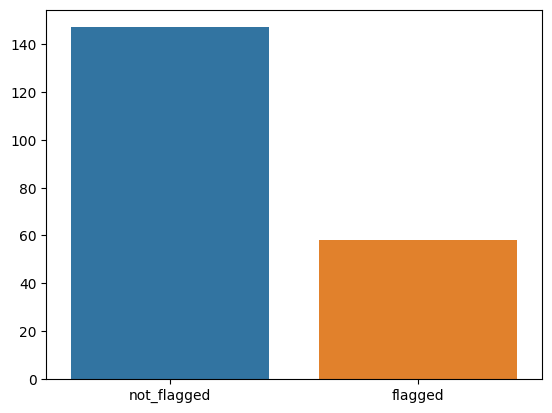

In [14]:
sns.barplot(y = list(data['class'].value_counts()) , x = ['not_flagged','flagged'] )

In [15]:
data['doc_len'] = list(data['response_text'].apply(lambda x : len(x)))

In [16]:
data.head()

,class,response_text,doc_len
0,not_flagged,I try and avoid this sort of conflict,37
1,flagged,Had a friend open up to me about his mental ad...,122
2,flagged,I saved a girl from suicide once. She was goin...,130
3,not_flagged,i cant think of one really...i think i may hav...,58
4,not_flagged,Only really one friend who doesn't fit into th...,381


<Axes: >

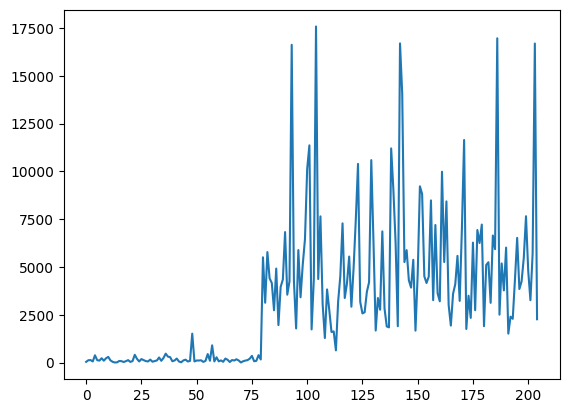

In [17]:
sns.lineplot(y = data['doc_len'].tolist() , x = list(range(data.shape[0])))

<Axes: >

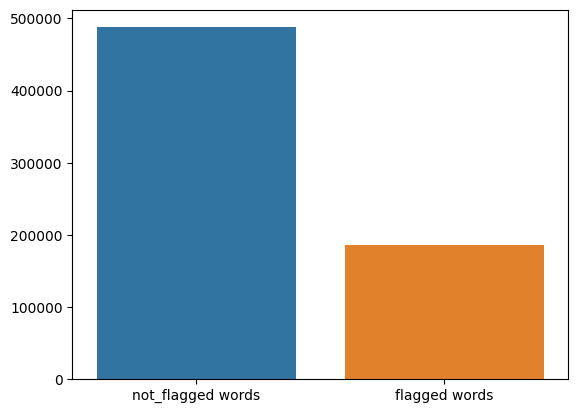

In [18]:
f_c = data[data['class']=='flagged']['doc_len'].sum()
n_f_c = data[data['class']=='not_flagged']['doc_len'].sum()
sns.barplot(y = [n_f_c , f_c] , x = ['not_flagged words','flagged words'])

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
doc = nlp(data['response_text'].tolist()[0])
doc2 = nlp(data['response_text'].tolist()[5])

In [21]:
tokens = list(doc)
for token in tokens:
  print(token.text , token.lemma_)

I I
try try
and and
avoid avoid
this this
sort sort
of of
conflict conflict


In [22]:
displacy.render(doc ,jupyter = True , style  = 'dep')

In [23]:
displacy.render(doc2 , style = 'ent' , jupyter = True)


In [24]:
# Text Preprocessing

In [25]:
def text_proc(text):
  doc = nlp(text.lower())
  tokens = [token.lemma_ for token in doc]
  not_conseder = [".",'"',"'","-","\r",'(',')','\x8a\x97¢']
  words = [token for token in tokens if not nlp.vocab[token].is_stop and token not in not_conseder] # stopword with lemmatization
  return ' '.join(words)

In [26]:
data['text_processed'] = data['response_text'].apply(text_proc)


In [27]:
data['doc_proc_len'] = data['text_processed'].apply(lambda x : len(x))


In [28]:
data.head()


,class,response_text,doc_len,text_processed,doc_proc_len
0,not_flagged,I try and avoid this sort of conflict,37,try avoid sort conflict,23
1,flagged,Had a friend open up to me about his mental ad...,122,friend open mental addiction weed life depressed,48
2,flagged,I saved a girl from suicide once. She was goin...,130,save girl suicide swallow bunch pill talk calm...,57
3,not_flagged,i cant think of one really...i think i may hav...,58,think ... think indirectly,26
4,not_flagged,Only really one friend who doesn't fit into th...,381,friend fit category therapist spiral pretty ti...,115


<Axes: >

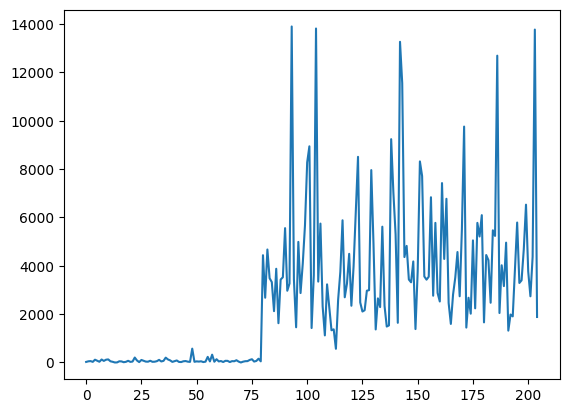

In [29]:
sns.lineplot(y = data['doc_proc_len'].tolist() , x = list(range(data.shape[0])))


<Axes: >

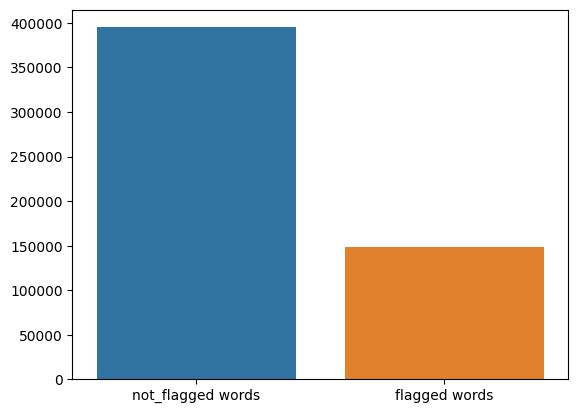

In [30]:
f_c = data[data['class']=='flagged']['doc_proc_len'].sum()
n_f_c = data[data['class']=='not_flagged']['doc_proc_len'].sum()
sns.barplot(y = [n_f_c , f_c] , x = ['not_flagged words','flagged words'])

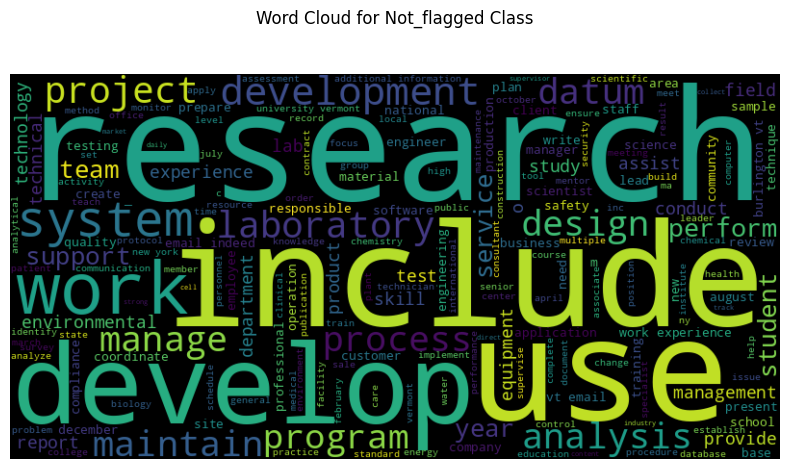

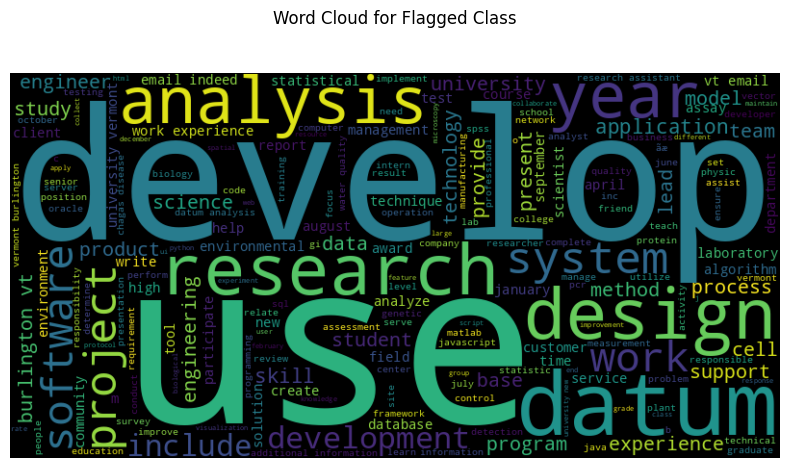

In [32]:
def visualize_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for cls in ['not_flagged', 'flagged']:
    text = ' '.join(data[data['class'] == cls]['text_processed'].tolist())
    visualize_wordcloud(text, f'Word Cloud for {cls.capitalize()} Class\n\n')
    print('\n\n\n')

In [33]:
# word2vec for word embedding word
def word2vec(text):
  doc = nlp(text)
  tokens_vec = [token.vector for token in doc]
  if len(tokens_vec) ==0: return np.zeros(96)
  return np.mean(tokens_vec,axis = 0).tolist()

In [34]:
data_vec = data['text_processed'].apply(word2vec).tolist()


In [35]:
new_data = pd.DataFrame(data_vec , columns = [f'feature_{i}' for i in range(96)])


In [37]:
new_data.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95
0,-0.261905,-0.350368,0.362800,0.267614,-0.680496,-0.116260,0.119037,0.304925,0.198447,-0.080022,...,-0.104133,-0.038202,-0.634752,0.255525,-0.130418,-0.258462,0.651903,0.478608,-0.254014,0.771279
1,0.359368,-0.556990,-0.127479,-0.124287,0.031134,0.098029,0.291796,0.404295,0.389227,-0.785471,...,-0.290174,0.263550,-0.703247,0.564819,-0.272231,0.039932,0.775548,1.226223,0.160507,0.146904
2,0.211139,-0.689701,0.115306,-0.190875,-0.266819,0.531425,0.257315,0.531328,0.151535,-0.373540,...,0.091977,-0.471855,-0.820894,0.628050,-0.155309,0.371245,1.027452,0.865137,-0.518889,0.229840
3,-0.272848,-0.280510,-0.134010,-0.616452,-0.568711,0.181053,-0.424265,-0.054026,-0.419500,-0.395304,...,0.053397,0.702495,-0.321630,0.365473,0.115128,-0.672301,0.511137,0.470719,-0.676314,0.714484
4,0.105522,-0.856440,0.218753,-0.355852,-0.132266,-0.155319,0.110395,0.634703,-0.084764,-0.485231,...,0.040384,0.186986,-0.655168,0.736558,0.170979,0.332704,0.870916,0.739263,-0.151193,0.138466


In [36]:
new_data.shape


(205, 96)

In [38]:
X = new_data
y = LabelEncoder().fit_transform(data['class'])

In [39]:
label_mapping = {sentiment: encoded for sentiment, encoded in zip(data['class'], LabelEncoder().fit_transform(data['class']))}

In [40]:
label_mapping

{'not_flagged': 1, 'flagged': 0}

RandomForest1
Train Score =  1.0
Val Score = 0.6956521739130435
Loss = 10.969807553209568
Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.73      0.94      0.82        51

    accuracy                           0.70        69
   macro avg       0.36      0.47      0.41        69
weighted avg       0.54      0.70      0.61        69

Confusion Matrix :
Xgboost1
Train Score =  0.9852941176470589
Val Score = 0.7391304347826086
Loss = 9.402692188465345
Classification report :
               precision    recall  f1-score   support

           0       0.50      0.11      0.18        18
           1       0.75      0.96      0.84        51

    accuracy                           0.74        69
   macro avg       0.63      0.54      0.51        69
weighted avg       0.69      0.74      0.67        69

Confusion Matrix :
NB1
Train Score =  0.7058823529411765
Val Score = 0.7391304347826086


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest2
Train Score =  1.0
Val Score = 0.6470588235294118
Loss = 12.721289431453114
Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.65      1.00      0.79        44

    accuracy                           0.65        68
   macro avg       0.32      0.50      0.39        68
weighted avg       0.42      0.65      0.51        68

Confusion Matrix :
Xgboost2
Train Score =  0.9416058394160584
Val Score = 0.6911764705882353
Loss = 11.131128252521473
Classification report :
               precision    recall  f1-score   support

           0       1.00      0.12      0.22        24
           1       0.68      1.00      0.81        44

    accuracy                           0.69        68
   macro avg       0.84      0.56      0.51        68
weighted avg       0.79      0.69      0.60        68



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix :
NB2
Train Score =  0.7518248175182481
Val Score = 0.6470588235294118
Loss = 12.721289431453114
Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.65      1.00      0.79        44

    accuracy                           0.65        68
   macro avg       0.32      0.50      0.39        68
weighted avg       0.42      0.65      0.51        68

Confusion Matrix :


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForest3
Train Score =  1.0
Val Score = 0.7647058823529411
Loss = 8.480859620968742
Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.76      1.00      0.87        52

    accuracy                           0.76        68
   macro avg       0.38      0.50      0.43        68
weighted avg       0.58      0.76      0.66        68

Confusion Matrix :
Xgboost3
Train Score =  0.9708029197080292
Val Score = 0.7058823529411765
Loss = 10.601074526210926
Classification report :
               precision    recall  f1-score   support

           0       0.17      0.06      0.09        16
           1       0.76      0.90      0.82        52

    accuracy                           0.71        68
   macro avg       0.46      0.48      0.46        68
weighted avg       0.62      0.71      0.65        68

Confusion Matrix :
NB3
Train Score =  0.6934306569343066
Val Score = 0.7647058823529411


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Confusion Matrix :


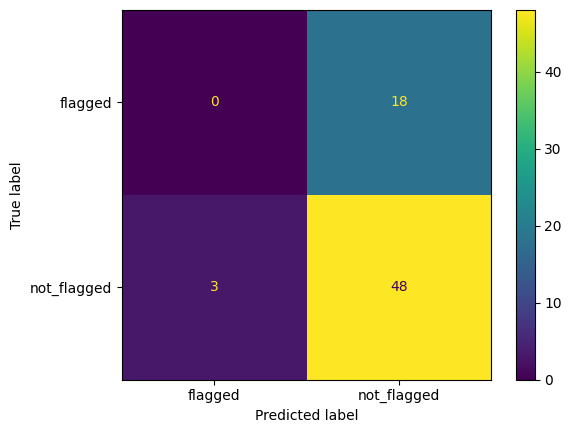

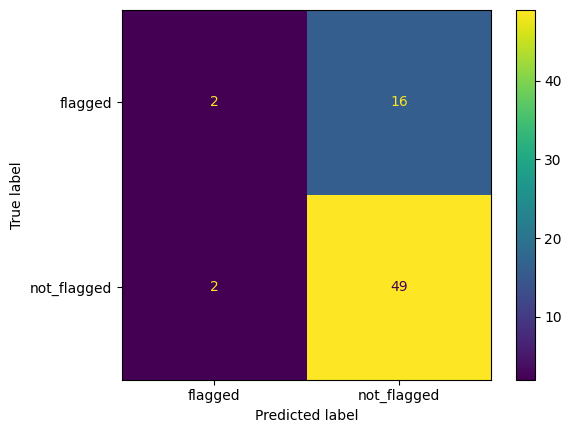

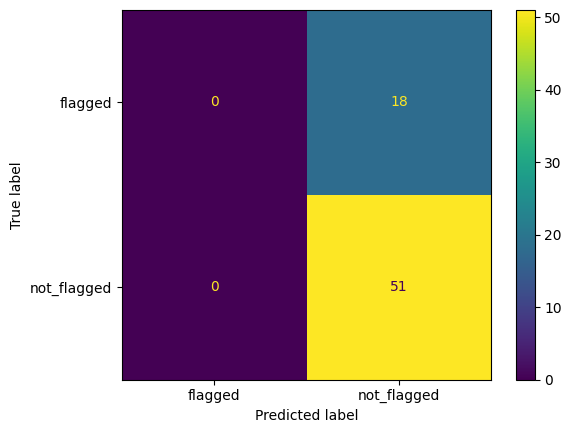

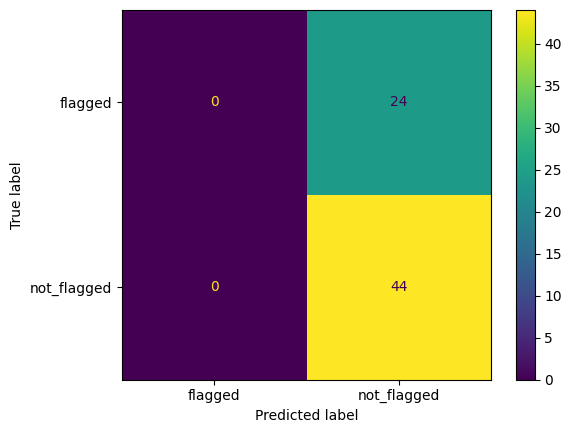

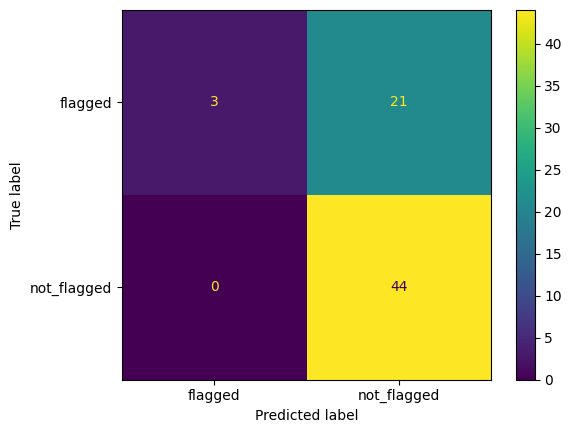

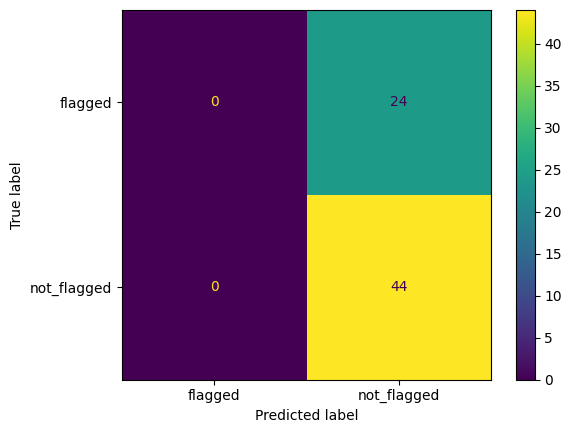

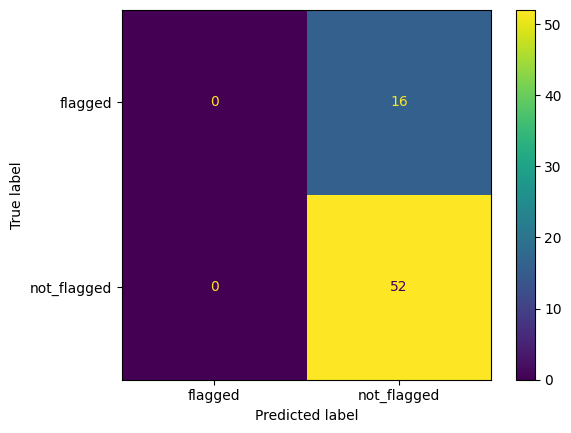

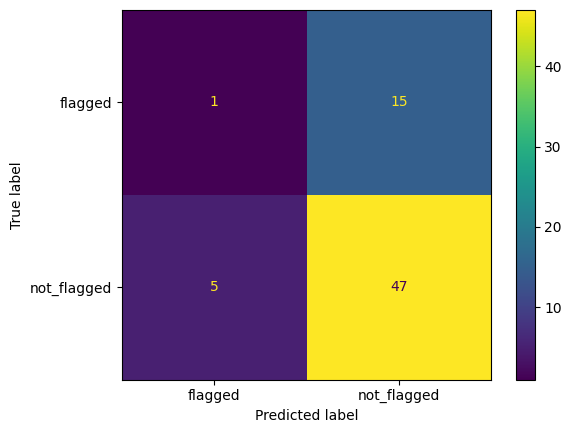

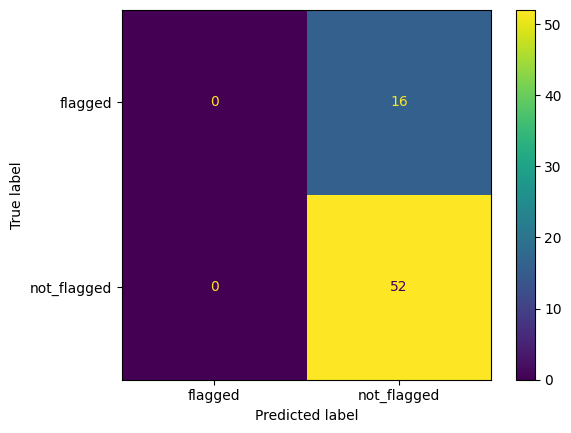

In [41]:
kf = KFold(n_splits = 3 ,shuffle = True , random_state = 42)
for fold ,(train_idx , val_idx) in enumerate(kf.split(X)):
  X_train , y_train  = np.array(X)[train_idx] , np.array(y)[train_idx]
  X_train_nb ,y_train_nb = X_train , y_train
  X_val , y_val = np.array(X)[val_idx], np.array(y)[val_idx]
  X_val_nb , y_val_nb = X_val , y_val
  rfr = RandomForestClassifier(n_estimators = 250 ,max_depth = 15 ,random_state = 42)
  xgb = XGBClassifier(learning_rate = 0.01 ,max_depth = 15 ,random_state = 42)
  nb = MultinomialNB()
  rfr.fit(X_train , y_train)
  xgb.fit(X_train , y_train)
  print(f'RandomForest{fold+1}')
  print(f'Train Score =  {rfr.score(X_train,y_train)}')
  print(f'Val Score = {rfr.score(X_val , y_val)}')
  print(f'Loss = {log_loss(y_val,rfr.predict(X_val))}')
  print(f'Classification report :\n {classification_report (y_val,rfr.predict(X_val))}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,rfr.predict(X_val)),display_labels = ["flagged","not_flagged"]).plot()}')
  print(f'Xgboost{fold+1}')
  print(f'Train Score =  {xgb.score(X_train,y_train)}')
  print(f'Val Score = {xgb.score(X_val , y_val)}')
  print(f'Loss = {log_loss(y_val,xgb.predict(X_val))}')
  print(f'Classification report :\n {classification_report (y_val,xgb.predict(X_val))}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,xgb.predict(X_val)),display_labels = ["flagged","not_flagged"]).plot()}')
  for i in range(X_train_nb.shape[0]):
    for j in range(X_train_nb.shape[1]):
        if(X_train_nb[i,j]< 0.0): X_train_nb[i,j] *= -1
  for i in range(X_val_nb.shape[0]):
    for j in range(X_val_nb.shape[1]):
        if(X_val_nb[i,j]< 0.0): X_val_nb[i,j] *= -1
  nb.fit(X_train_nb,y_train_nb)
  print(f'NB{fold+1}')
  print(f'Train Score =  {nb.score(X_train_nb,y_train_nb)}')
  print(f'Val Score = {nb.score(X_val_nb , y_val_nb)}')
  print(f'Loss = {log_loss(y_val_nb,nb.predict(X_val_nb))}')
  print(f'Classification report :\n {classification_report (y_val_nb,nb.predict(X_val_nb))}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val_nb ,nb.predict(X_val_nb)),display_labels = ["flagged","not_flagged"]).plot()}')